In [1]:
!pip install tensorflow==2.10.0 pandas graphviz ffmpeg plotly pydot scipy split-folders matplotlib==3.7.3 seaborn opencv-python scikit-learn tqdm tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!pip install keras-tuner==1.3.5

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
from keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [4]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import pandas as pd
import glob
import plotly.express as px
import matplotlib.pyplot as plt
from PIL import Image


new_files = glob.glob("./Data/*/*.png")
data = []
for _file in new_files:
    classname = _file.split("\\")[1]
    data.append({"file": _file, "class": classname})

df = pd.DataFrame(data)

In [6]:
df

file               class
0           ./Data\Amoladores\1597211863834b4bIFNQa.png          Amoladores
1     ./Data\Amoladores\164Amoladores4SaltoParoAmazo...          Amoladores
2     ./Data\Amoladores\164Amoladores6SaltoParoAmazo...          Amoladores
3     ./Data\Amoladores\164Amoladores8SaltoParoAmazo...          Amoladores
4     ./Data\Amoladores\164AmoladoresSaltoParoAmazon...          Amoladores
...                                                 ...                 ...
1770               ./Data\Pinturas Rupestres\WnrQsE.png  Pinturas Rupestres
1771               ./Data\Pinturas Rupestres\WnrToa.png  Pinturas Rupestres
1772               ./Data\Pinturas Rupestres\WnrToi.png  Pinturas Rupestres
1773  ./Data\Pinturas Rupestres\xjWe7plIzG9xqBf0O6FM...  Pinturas Rupestres
1774      ./Data\Pinturas Rupestres\yucatan -mexico.png  Pinturas Rupestres

[1775 rows x 2 columns]

In [7]:
# Extract class names
class_names = sorted(df['class'].unique())
# Class Distribution
class_dis = [df[df['class']==name].shape[0] for name in class_names]
class_names_label = {class_name:i for i, class_name in enumerate(class_names)}
nb_classes = len(class_names_label)
class_names_label

{'Amoladores': 0,
 'Bateas o metates': 1,
 'Cupulas': 2,
 'Dolmenes': 3,
 'Esferas liticas': 4,
 'Geoglifos': 5,
 'Menhires': 6,
 'Micropetroglifos': 7,
 'Monolitos': 8,
 'Petroglifos': 9,
 'Pinturas Rupestres': 10}

In [8]:
print(class_dis)

[46, 29, 223, 86, 125, 44, 133, 94, 125, 406, 464]


In [9]:
fig = px.pie(names=class_names, values=class_dis, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [10]:
# Preparación de los folders train, test y validation
"""
import splitfolders

train_ratio = 0.75
test_ratio = 0.15
validation_ratio = 0.10

splitfolders.ratio("./Data", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values
"""

'\nimport splitfolders\n\ntrain_ratio = 0.75\ntest_ratio = 0.15\nvalidation_ratio = 0.10\n\nsplitfolders.ratio("./Data", output="output", seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False) # default values\n'

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import keras_tuner as kt
from tensorflow import keras
import cv2
import os
from tqdm import tqdm # Progress bar
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import numpy as np

root_path: str = './output'

In [12]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3 # 3 for Colored Images and 1 for Grayscale Images
BATCH_SIZE=16 # BATCH Size for hyper tunner
EPOCHS=10 # Epochs for Hyper tunner

if FAST_RUN:
    EPOCHS= 5

def load_data():

    datasets = ['/train',
                '/val',
                '/test']
    output = []

    # Iterate through training and test sets
    for dataset in datasets:
        dataset = root_path+dataset
        images = []
        labels = []

        print("Loading {}".format(dataset))

        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            label = class_names_label[folder]

            # Iterate through each image in our folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                # Open and resize the img
                image = cv2.imread(img_path,cv2.IMREAD_COLOR)

                if image is None: # To account for broken images
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                image = cv2.resize(image, IMAGE_SIZE)
                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

        images = np.array(images)
        labels = np.array(labels)

        output.append((images, labels))


    return output

## Asignación de los grupos de entrenamiento, validación y pruebas

In [13]:
(train_images, train_labels), (val_images, val_labels), (test_images, test_labels) = load_data()

Loading ./output/train


100%|██████████| 743/743 [00:02<00:00, 350.92it/s]


Loading ./output/val


100%|██████████| 92/92 [00:00<00:00, 395.15it/s]


Loading ./output/test


100%|██████████| 94/94 [00:00<00:00, 399.26it/s]


## Validación de los tamaños de las etiquetas y tensores de datos

In [14]:
print(train_images.shape)
print(train_labels.shape)
print(val_images.shape)
print(val_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1414, 256, 256, 3)
(1414,)
(172, 256, 256, 3)
(172,)
(188, 256, 256, 3)
(188,)


## Generación de datos de muestra

In [15]:
%matplotlib inline

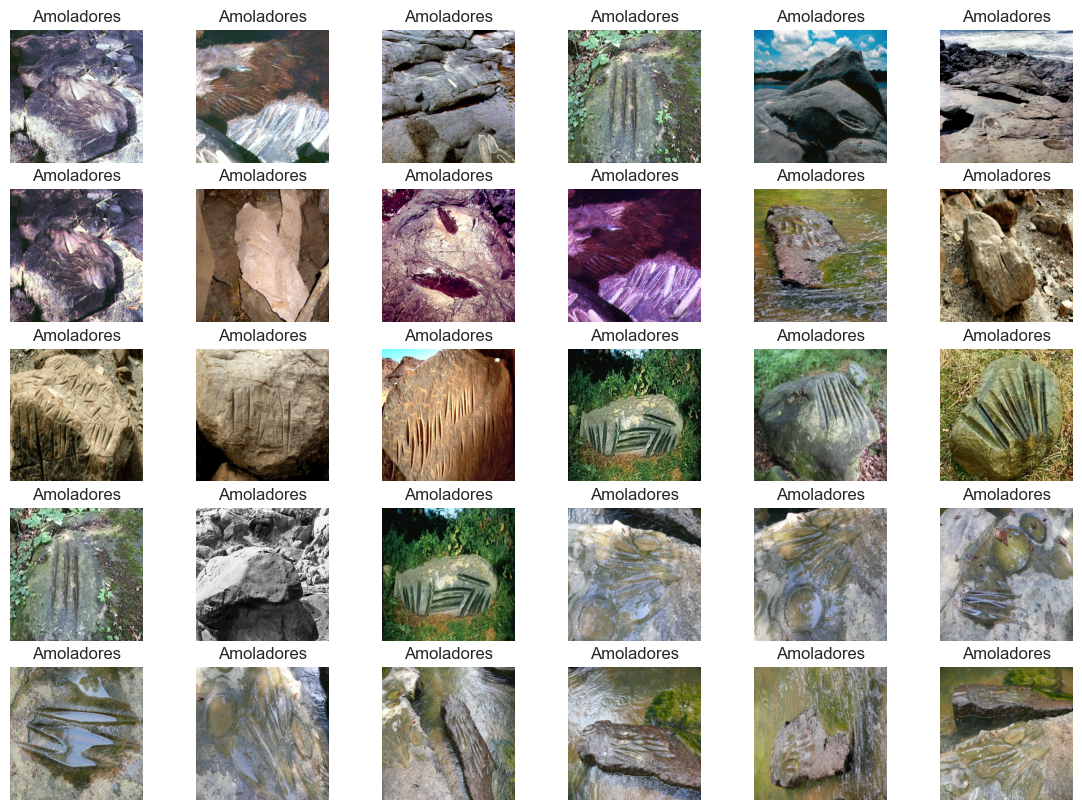

In [16]:
fig = plt.figure(figsize=(14,10))
for n in range(1, 31):
    fig.add_subplot(5, 6, n)
    img = train_images[n]
    plt.imshow(img)
    plt.title(class_names[train_labels[n]])
    plt.axis('off')

## Categorización de las etiquetas del dataset

In [17]:
from tensorflow.keras.utils import to_categorical
train_labels=to_categorical(train_labels,0)
val_labels=to_categorical(val_labels,0)
test_labels=to_categorical(test_labels,0)
train_labels.shape,val_labels.shape,test_labels.shape

((1414, 11), (172, 11), (188, 11))

## Validación de categorización del dataset

In [18]:
train_labels[1000:1005]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], dtype=float32)

In [19]:
test_labels[0:5]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## Entremezclamiento de los datos de entrenamiento

In [20]:
train_images, train_labels = shuffle(train_images, train_labels, random_state=42)
val_images, val_labels = shuffle(val_images, val_labels, random_state=42)

## Definición de los DataGenerators (Virtual Data Augmentation)

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
)

train_generator= train_datagen.flow(
    train_images,
    train_labels,
    batch_size= BATCH_SIZE)

val_generator= train_datagen.flow(
    val_images,
    val_labels,
    batch_size= BATCH_SIZE)

## Arquitectura del modelo

In [22]:
# f1-score metric

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
import keras_tuner
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import tensorflow_addons as tfa


def build_model(hp):
    model = keras.Sequential()
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_1_filter', min_value=16, max_value=64, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(IMAGE_WIDTH,IMAGE_HEIGHT,IMAGE_CHANNELS)
    ))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_2_filter', min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
        activation='relu'))
    
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=32),
        kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
        activation='relu'))
    model.add(keras.layers.Conv2D(
        filters=hp.Int('conv_4_filter', min_value=32, max_value=512, step=32),
        kernel_size=hp.Choice('conv_4_kernel', values = [3,5]),
        activation='relu'))

    
    model.add(keras.layers.MaxPooling2D((2,2)))
    model.add(keras.layers.MaxPooling2D((2,2)))

    model.add(keras.layers.Flatten())

    model.add(keras.layers.Dense(
        units=hp.Int('dense_1_units', min_value=128, max_value=512, step=128),
        activation='relu'
    ))
    model.add(keras.layers.Dense(
        units=hp.Int('dense_2_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    model.add(keras.layers.Dense(
        units=hp.Int('dense_3_units', min_value=32, max_value=128, step=32),
        activation='relu'
    ))
    model.add(keras.layers.Dense(
        units=hp.Int('dense_4_units', min_value=32, max_value=64, step=32),
        activation='relu'
    ))
    
    model.add(keras.layers.Dropout(
        rate=hp.Float('dropout_rate', min_value=0.0, max_value=0.5, default=0.25, step=0.05)
    ))
    # Dense Softmax Layer debe tener el número total de clases
    model.add(keras.layers.Dense(11, activation='softmax'))

    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-1,1e-2, 1e-3, 1e-4])),
              loss=tfa.losses.SigmoidFocalCrossEntropy(),
              metrics=['accuracy', f1_score])

    return model

E:\proyectos\master\TFM\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning:



TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 


E:\proyectos\master\TFM\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning:

Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're u

In [ ]:
from keras_tuner import RandomSearch
from keras_tuner import HyperParameters

import IPython

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [25]:
from keras_tuner import Hyperband, Objective

tuner_search=Hyperband(build_model,
                       objective=Objective('f1_score', direction='max'),
                       max_epochs = EPOCHS,
                       factor = 3,
                       directory='output',
                       project_name="ModelScratch+Op")

INFO:tensorflow:Reloading Tuner from output\ModelScratch+Op\tuner0.json


In [26]:
tuner_search.search(train_generator,
                    epochs=3,
                    validation_data=(val_generator),
                    validation_split=0.1,
                    callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [27]:
model=tuner_search.get_best_models(num_models=1)[0]

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 252, 252, 16)      1216      
                                                                 
 conv2d_1 (Conv2D)           (None, 250, 250, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 248, 248, 128)     36992     
                                                                 
 conv2d_3 (Conv2D)           (None, 246, 246, 224)     258272    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 123, 123, 224)    0         
 )                                                               
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 224)      0         
 2D)                                                    

In [24]:
checkpoint = keras.callbacks.ModelCheckpoint('ScratchModel+Op.h5',monitor='val_f1_score',
save_best_only = True,
mode= 'max')

In [25]:
callbacks = [checkpoint]

In [31]:
H = model.fit(train_generator,
              epochs=120,
              batch_size=BATCH_SIZE,
              validation_data=val_generator,
              callbacks=callbacks)

Epoch 1/120
89/89 [==============================] - 159s 1s/step - loss: 0.2618 - accuracy: 0.5693 - f1_score: 0.3515 - val_loss: 0.2540 - val_accuracy: 0.5523 - val_f1_score: 0.3214
Epoch 2/120
89/89 [==============================] - 62s 697ms/step - loss: 0.2551 - accuracy: 0.5700 - f1_score: 0.3390 - val_loss: 0.2507 - val_accuracy: 0.5407 - val_f1_score: 0.3887
Epoch 3/120
89/89 [==============================] - 39s 431ms/step - loss: 0.2443 - accuracy: 0.6096 - f1_score: 0.3657 - val_loss: 0.2416 - val_accuracy: 0.5581 - val_f1_score: 0.2783
Epoch 4/120
89/89 [==============================] - 38s 426ms/step - loss: 0.2414 - accuracy: 0.6004 - f1_score: 0.3548 - val_loss: 0.2443 - val_accuracy: 0.5930 - val_f1_score: 0.3720
Epoch 5/120
89/89 [==============================] - 39s 438ms/step - loss: 0.2354 - accuracy: 0.6011 - f1_score: 0.3916 - val_loss: 0.2396 - val_accuracy: 0.5872 - val_f1_score: 0.3348
Epoch 6/120
89/89 [==============================] - 39s 432ms/step - lo

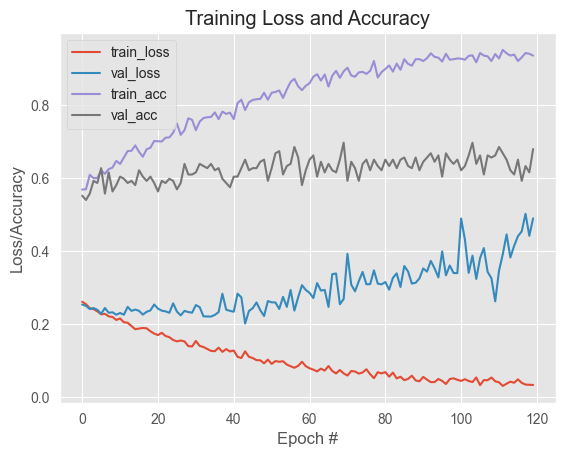

In [32]:
import matplotlib.pyplot as plt
import random

final_epochs: int = len(H.history["loss"])

# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, final_epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, final_epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, final_epochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, final_epochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

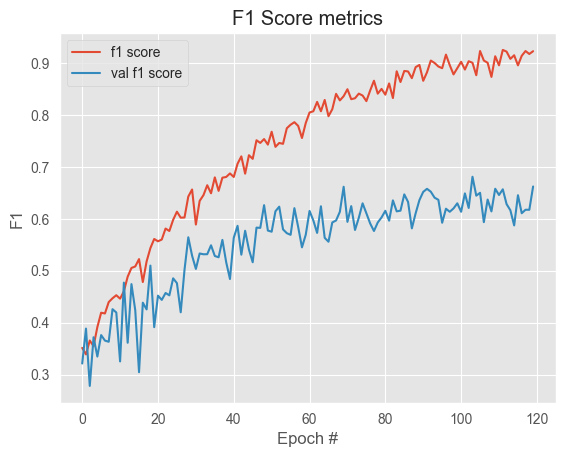

In [33]:
# Muestro gráfica de accuracy y losses
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, final_epochs), H.history["f1_score"], label="f1 score")
plt.plot(np.arange(0, final_epochs), H.history["val_f1_score"], label="val f1 score")
plt.title("F1 Score metrics")
plt.xlabel("Epoch #")
plt.ylabel("F1")
plt.legend()

In [26]:
import random
def classification_evaluation(classification, predicted_labels, test_labels, test_images):
    if classification== "correct":
        indices_list = np.where(predicted_labels == test_labels)[0]
    else:
        indices_list = np.where(predicted_labels!= test_labels)[0]
    test_images_filtered= [test_images[i] for i in indices_list]
    images_labels_original= [test_labels[i] for i in indices_list]
    images_labels_predicted= [pred_labels[i] for i in indices_list]
    print(f"{len(test_images_filtered)} images were classified {classification.upper()} out of a total of {len(test_images)} in the Test dataset")

    unique, counts = np.unique(images_labels_original, return_counts=True)
    for i in range(0,len(unique)):
        print(f"for category {unique[i]} the number of {classification.upper()} classified images were: {counts[i]}")

    # Plot some of the misclassified images
    print("\n\n")
    fig,ax=plt.subplots(5,2)
    fig.suptitle(f"Sample of {classification.upper()} Classified Images", fontsize=20)
    fig.set_size_inches(15,15)
    for i in range(5):
        for j in range (2):
            l=random.randint(0,len(test_images_filtered))
            ax[i,j].imshow(test_images_filtered[l])
            ax[i,j].set_title("Predicted: "+ str(class_names[images_labels_predicted[l]]) + "\n"+"Actual: "+str(class_names[images_labels_original[l]]))
    plt.tight_layout()

In [27]:
from keras.models import load_model
model = load_model('ScratchModel+Op.h5', custom_objects={"f1_score": f1_score, "SigmoidFocalCrossEntropy": tfa.losses.SigmoidFocalCrossEntropy})

In [28]:
val_loss = model.evaluate(val_images, val_labels)
test_loss = model.evaluate(test_images, test_labels)

6/6 [==============================] - 3s 572ms/step - loss: 8.3338 - accuracy: 0.4415 - f1_score: 0.4427


In [29]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis = 1)
test_labels_vector = np.argmax(test_labels, axis = 1)

6/6 [==============================] - 1s 188ms/step


In [30]:
from sklearn import metricsRe
print(metrics.classification_report(test_labels_vector, pred_labels, zero_division=False))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         5
           1       0.00      0.00      0.00         3
           2       0.25      0.20      0.22        20
           3       0.50      0.14      0.22        14
           4       0.33      0.67      0.44        18
           5       0.40      0.40      0.40         5
           6       0.80      0.31      0.44        13
           7       1.00      0.54      0.70        13
           8       0.70      0.39      0.50        18
           9       0.33      0.77      0.46        35
          10       0.95      0.41      0.57        44

    accuracy                           0.44       188
   macro avg       0.48      0.35      0.36       188
weighted avg       0.58      0.44      0.44       188


## Confussion Matrix

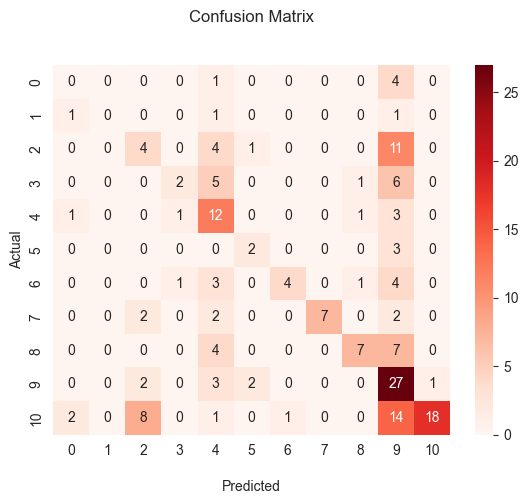

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Generar matriz de confusión
cf_matrix = confusion_matrix(test_labels_vector, pred_labels)
ax = sns.heatmap(cf_matrix, annot=True, fmt=".0f", cmap='Reds')
sns.set(rc={"figure.figsize":(16, 5)})
ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted')
ax.set_ylabel('Actual');

# Mostrar la matriz
plt.show()

105 images were classified INCORRECT out of a total of 188 in the Test dataset
for category 0 the number of INCORRECT classified images were: 5
for category 1 the number of INCORRECT classified images were: 3
for category 2 the number of INCORRECT classified images were: 16
for category 3 the number of INCORRECT classified images were: 12
for category 4 the number of INCORRECT classified images were: 6
for category 5 the number of INCORRECT classified images were: 3
for category 6 the number of INCORRECT classified images were: 9
for category 7 the number of INCORRECT classified images were: 6
for category 8 the number of INCORRECT classified images were: 11
for category 9 the number of INCORRECT classified images were: 8
for category 10 the number of INCORRECT classified images were: 26


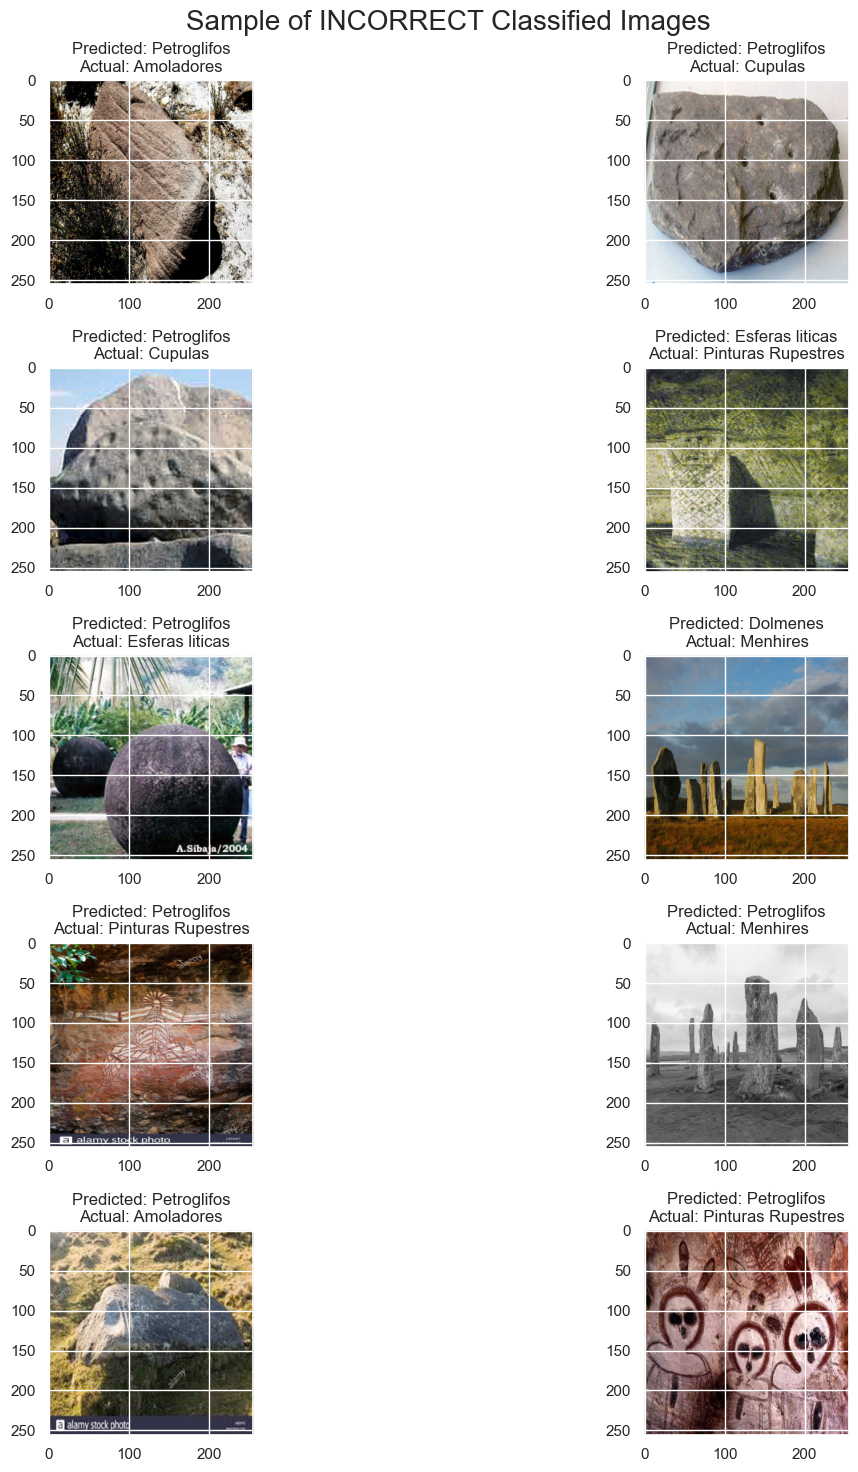

In [32]:
classification_evaluation("incorrect", pred_labels, test_labels_vector, test_images)

In [33]:
!pip install pydot graphviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [34]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\bin'
import keras.utils
from importlib import reload
reload(keras.utils)

<module 'keras.utils' from 'E:\\proyectos\\master\\TFM\\venv\\lib\\site-packages\\keras\\utils\\__init__.py'>

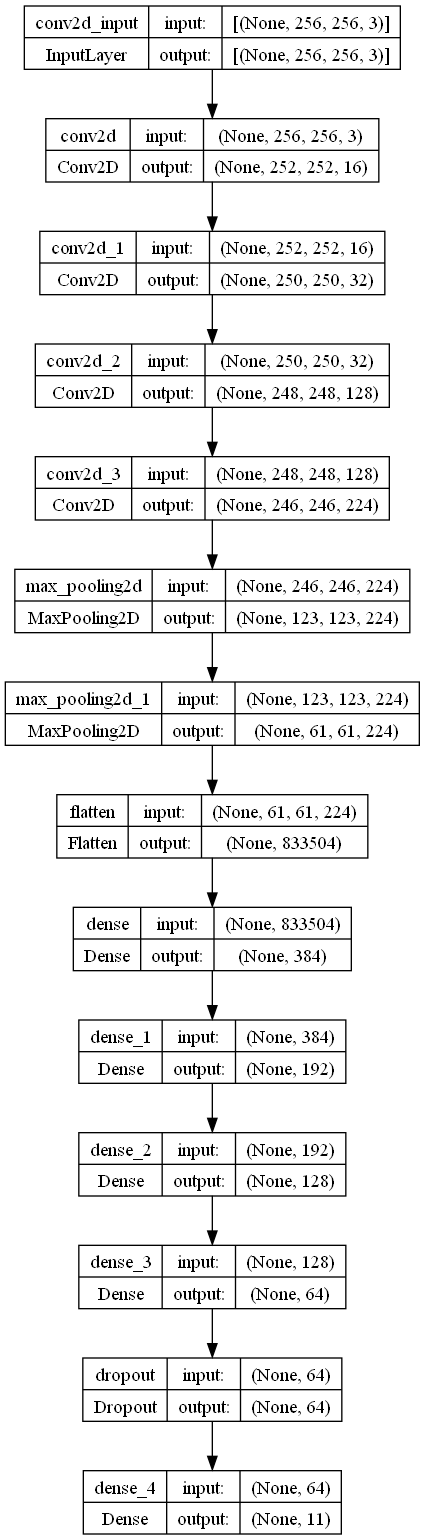

In [35]:
from keras.utils import plot_model
plot_model(model,show_shapes=True)